# Mean Square Displacement (MSD)

This is a validation for the E-Cell4 library. Here, we test a mean square displacement (MSD) for each simulation algorithms.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
from ecell4 import *

Making a model for all. A single species `A` is defined. The radius is 5 nm, and the diffusion coefficient is 1um^2/s:

In [2]:
radius, D = 0.005, 1
m = NetworkModel()
m.add_species_attribute(Species("A", str(radius), str(D)))

Create a random number generator, which is used through whole simulations below:

In [3]:
rng = GSLRandomNumberGenerator()
rng.seed(0)

## Distribution along each axis

First, a distribution along each axis is tested. The distribution after the time `t` should follow the normal distribution with mean 0 and variance `2Dt`.

In [4]:
def singlerun1(f, duration):
    w = f.create_world(Real3(1, 1, 1))
    w.bind_to(m)
    w.add_molecules(Species("A"), 60)

    obs1 = FixedIntervalTrajectoryObserver(0.01)
    sim = f.create_simulator(w)
    sim.run(duration, obs1)
    
    distances = []
    for data in obs1.data():
        distances.extend(tuple(data[-1] - data[0]))
    return distances

def plot_displacements(N, f, duration):
    distances = []
    for _ in range(N):
        distances.extend(singlerun1(f, duration))

    _, bins, _ = plt.hist(distances, bins=30, normed=True, facecolor='green', alpha=0.5, label='Simulation')
    xmax = max(abs(bins[0]), abs(bins[-1]))
    x = numpy.linspace(-xmax, +xmax, 101)
    gauss = lambda x, sigmasq: numpy.exp(-0.5 * x * x / sigmasq) / numpy.sqrt(2 * numpy.pi * sigmasq)
    plt.plot(x, gauss(x, sum(numpy.array(distances) ** 2) / len(distances)), 'k--', label='Fitting')
    plt.plot(x, gauss(x, 2 * D * duration), 'r-', label='Expected')
    plt.xlim(x[0], x[-1])
    plt.ylim(0, 1)
    plt.xlabel('Displacement')
    plt.ylabel('Frequenecy')
    plt.legend(loc='best', shadow=True)
    plt.show()
    return distances

Simulating with `egfrd`:

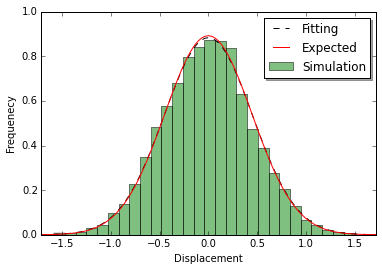

In [5]:
distances1 = plot_displacements(50, egfrd.EGFRDFactory(Integer3(4, 4, 4), rng), 0.1)

Simulating with `spatiocyte`:

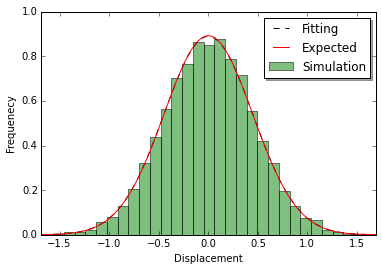

In [6]:
distances2 = plot_displacements(50, spatiocyte.SpatiocyteFactory(radius, rng), 0.1)

## Mean square displacement

A mean square displacement after the time `t` is euqal to the variance above. The one of a diffusion in volume is `6Dt`. `ecell4.FixedIntervalTrajectoryObserver` enables to track a trajectory of a particle over periodic boundaries.

In [7]:
def test_mean_square_displacement(N, func, *args):
    t, mean = func(*args)
    for _ in range(N - 1):
        mean += func(*args)[1]
    mean /= N
    return t, mean

In [8]:
def singlerun2(f, duration):
    w = f.create_world(Real3(1, 1, 1))
    w.bind_to(m)
    w.add_molecules(Species("A"), 60)

    obs1 = FixedIntervalTrajectoryObserver(0.01)
    sim = f.create_simulator(w)
    sim.run(duration, obs1)

    t = numpy.array(obs1.t())
    mean = sum(numpy.array([length_sq(pos - data[0]) for pos in data])
               for data in obs1.data()) / obs1.num_tracers()
    return t, mean

Simulating with `egfrd`:

In [9]:
t, mean1 = test_mean_square_displacement(15, singlerun2, egfrd.EGFRDFactory(Integer3(4, 4, 4), rng), 3)

Simulating with `spatiocyte`:

In [10]:
t, mean2 = test_mean_square_displacement(15, singlerun2, spatiocyte.SpatiocyteFactory(radius, rng), 3)

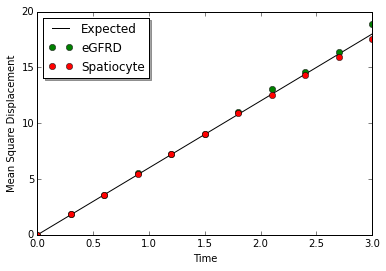

In [11]:
plt.plot(t, 6 * D * t, 'k-', label="Expected")
plt.plot(t[::30], mean1[::30], 'go', label="eGFRD")
plt.plot(t[::30], mean2[::30], 'ro', label="Spatiocyte")
plt.xlim(t[0], t[-1])
plt.legend(loc="best", shadow=True)
plt.xlabel("Time")
plt.ylabel("Mean Square Displacement")
plt.show()

##  Mean square displacement in a cube

Here, we test a mean square diplacement in a cube. For the periodic boundaries, particles cannot escape from World, and thus the displacement for each axis is less than a half of the World size. In `meso` simulations, unlike `egfrd` and `spatiocyte`, each molecule doesn't have its `ParticleID`. `meso` is just validated in this condition because `FixedIntervalTrajectoryObserver` is only available with `ParticleID`.

In [12]:
def singlerun3(f, duration):
    w = f.create_world(Real3(1, 1, 1))
    L_11, L_2 = 1.0 / 11, 1.0 / 2
    w.bind_to(m)
    NA = 12
    w.add_molecules(Species("A"), NA, AABB(Real3(5, 5, 5) * L_11, Real3(6, 6, 6) * L_11))

    sim = f.create_simulator(w)
 
    t, retval = [0.0], [sum(length_sq(p.position() - Real3(L_2, L_2, L_2)) for pid, p in w.list_particles_exact(Species("A"))) / NA]
    for i in range(20):
        sim.run(duration / 20)
        mean = sum(length_sq(p.position() - Real3(L_2, L_2, L_2)) for pid, p in w.list_particles_exact(Species("A"))) / NA
        t.append(sim.t())
        retval.append(mean)
    return numpy.array(t), numpy.array(retval)

Simulating with `egfrd`:

In [13]:
t, mean1 = test_mean_square_displacement(50, singlerun3, egfrd.EGFRDFactory(Integer3(4, 4, 4), rng), 0.15)

Simulating with `spatiocyte`:

In [14]:
t, mean2 = test_mean_square_displacement(50, singlerun3, spatiocyte.SpatiocyteFactory(radius, rng), 0.15)

Simulating with `meso`:

In [15]:
t, mean3 = test_mean_square_displacement(50, singlerun3, meso.MesoscopicFactory(Integer3(11, 11, 11), rng), 0.15)

Mean square displacement at the uniform distribution in a cube is calculated as follows:

$\int_0^1\int_0^1\int_0^1 dxdydz\ (x-0.5)^2+(y-0.5)^2+(z-0.5)^2=3\left[\frac{(x-0.5)^3}{3}\right]_0^1=0.25$

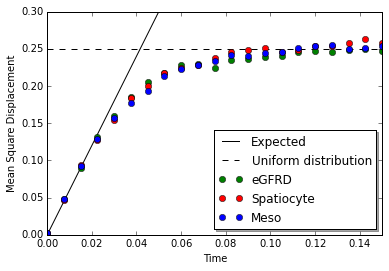

In [16]:
plt.plot(t, 6 * D * t, 'k-', label="Expected")
plt.plot((t[0], t[-1]), (0.25, 0.25), 'k--', label='Uniform distribution')
plt.plot(t, mean1, 'go', label="eGFRD")
plt.plot(t, mean2, 'ro', label="Spatiocyte")
plt.plot(t, mean3, 'bo', label="Meso")
plt.xlim(t[0], t[-1])
plt.ylim(0, 0.3)
plt.legend(loc="best", shadow=True)
plt.xlabel("Time")
plt.ylabel("Mean Square Displacement")
plt.show()

## Mean square displacement in 2D

Spatial simulation with a structure is only supported by `spatiocyte` and `meso` now. Here, mean square displacement on a planar surface is tested for these algorithms.

First, a model is defined with a species `A` which has the same attributes with above except for the location named `M`.

In [17]:
radius, D = 0.005, 1
m = NetworkModel()
m.add_species_attribute(Species("A", str(radius), str(D), "M"))

Mean square displacement of a 2D diffusion must follow `4Dt`. The diffusion on a planar surface parallel to yz-plane at the center is tested with `spatiocyte`.

In [18]:
def singlerun4(f, duration):
    w = f.create_world(Real3(1, 1, 1))
    w.bind_to(m)
    w.add_structure(Species("M"), PlanarSurface(Real3(0.5, 0.5, 0.5), Real3(0, 1, 0), Real3(0, 0, 1)))
    w.add_molecules(Species("A"), 60)

    obs1 = FixedIntervalTrajectoryObserver(0.01, [pid for pid, p in w.list_particles_exact(Species("A"))])
    sim = f.create_simulator(w)
    sim.run(duration, obs1)

    t = numpy.array(obs1.t())
    mean = sum(numpy.array([length_sq(pos - data[0]) for pos in data])
               for data in obs1.data()) / obs1.num_tracers()
    return t, mean

Simulating with `spatiocyte`:

In [19]:
t, mean2 = test_mean_square_displacement(100, singlerun4, spatiocyte.SpatiocyteFactory(radius, rng), 10)

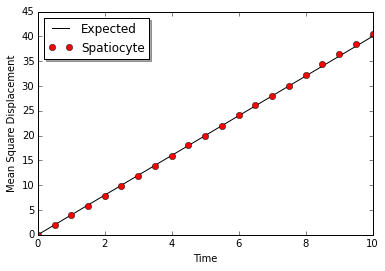

In [20]:
plt.plot(t, 4 * D * t, 'k-', label="Expected")
plt.plot(t[::50], mean2[::50], 'ro', label="Spatiocyte")
plt.xlim(t[0], t[-1])
plt.legend(loc="best", shadow=True)
plt.xlabel("Time")
plt.ylabel("Mean Square Displacement")
plt.show()

Mean square displacement on a planar surface restricted in a cube by periodic boundaries is compared between `meso` and `spatiocyte`.

In [21]:
def singlerun5(f, duration):
    w = f.create_world(Real3(1, 1, 1))
    L_11, L_2 = 1.0 / 11, 1.0 / 2
    w.bind_to(m)
    NA = 12
    w.add_structure(Species("M"), PlanarSurface(Real3(0.5, 0.5, 0.5), Real3(0, 1, 0), Real3(0, 0, 1)))
    w.add_molecules(Species("A"), NA, AABB(Real3(5, 5, 5) * L_11, Real3(6, 6, 6) * L_11))

    sim = f.create_simulator(w)
 
    t, retval = [0.0], [sum(length_sq(p.position() - Real3(L_2, L_2, L_2)) for pid, p in w.list_particles_exact(Species("A"))) / NA]
    for i in range(20):
        sim.run(duration / 20)
        mean = sum(length_sq(p.position() - Real3(L_2, L_2, L_2)) for pid, p in w.list_particles_exact(Species("A"))) / NA
        t.append(sim.t())
        retval.append(mean)
    return numpy.array(t), numpy.array(retval)

Simulating with `spatiocyte`:

In [22]:
t, mean2 = test_mean_square_displacement(50, singlerun5, spatiocyte.SpatiocyteFactory(radius, rng), 0.15)

Simulating with `meso`:

In [23]:
t, mean3 = test_mean_square_displacement(50, singlerun5, meso.MesoscopicFactory(Integer3(11, 11, 11), rng), 0.15)

Mean square displacement at the uniform distribution on a plane is calculated as follows:

$\int_0^1\int_0^1 dxdydz\ (0.5-0.5)^2+(y-0.5)^2+(z-0.5)^2=2\left[\frac{(x-0.5)^3}{3}\right]_0^1=\frac{1}{6}$

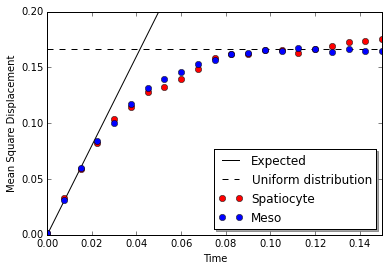

In [24]:
plt.plot(t, 4 * D * t, 'k-', label="Expected")
plt.plot((t[0], t[-1]), (0.5 / 3, 0.5 / 3), 'k--', label='Uniform distribution')
plt.plot(t, mean2, 'ro', label="Spatiocyte")
plt.plot(t, mean3, 'bo', label="Meso")
plt.xlim(t[0], t[-1])
plt.ylim(0, 0.2)
plt.legend(loc="best", shadow=True)
plt.xlabel("Time")
plt.ylabel("Mean Square Displacement")
plt.show()

Plottig the trajectory of particles on a surface with `spatiocyte`:

In [25]:
obs = FixedIntervalTrajectoryObserver(0.01)
surface = PlanarSurface(Real3(0.5, 0.5, 0.5), Real3(0, 1, 0), Real3(0, 0, 1))
run_simulation(5, model=m, y0={"A": 10}, structures={"M": surface}, observers=obs,
               factory=spatiocyte.SpatiocyteFactory(radius, rng), return_type=None)
_ = viz.plot_trajectory(obs)